# Adım 1: SparkSessionGerekli Kütüphaneleri Ekleme ve Yaratma
Gerekli kütüphanelerimiz ekliyoruz. SparkSession, Spark'taki tüm işlevlere bir giriş noktasıdır ve PySpark'ta bir veri çerçevesi oluşturmak istiyorsanız gereklidir.

In [244]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [245]:
spark = SparkSession.builder.appName("Final_Odevi").getOrCreate()

Bu kod, PySpark'i kullanarak "spark" adlı bir SparkSession nesnesi oluşturur.

- appName parametresi, uygulamanın adını "Final_Odevi" olarak ayarlar.

- SparkSession.builder, yığın dışı belleği etkinleştirir ve yığın dışı belleğin boyutunu 10 gigabayt olarak ayarlar.

- Son olarak, getOrCreate() yöntemi mevcut bir SparkSession döndürür veya yoksa yeni bir tane oluşturur.

# Adım 2: DataFrame Oluşturma

In [246]:
df = spark.read.csv('eCommerce.csv', header=True, escape="\"")

Csv dosyasındaki virgülleri avoid edebilmek için bir escape karakteri tanımladık.

Show() işlevini kullanarak veri çerçevesinin başına bir göz atalım

In [247]:
# Code Explanation
# - The second argument 0 specifies that the method should not truncate the displayed columns.
# - This is useful when working with large datasets where the default behavior is to truncate the columns to fit the screen.
# - By setting the second argument to 0, all columns will be displayed without truncation

df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+

|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+

|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|

|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|

|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|

|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|

|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|

+---------+---------+-----------------------------------+-------

Veri çerçevesi 8 feature’dan oluşur:

- InvoiceNo: Her müşteri faturasının benzersiz tanımlayıcısı.

- StockCode: Stoktaki her öğenin benzersiz tanımlayıcısı.

- Description: Müşteri tarafından satın alınan ürün.

- Quantity: Bir müşteri tarafından tek bir faturada satın alınan her bir öğenin numarası.

- InvoiceDate: Satın alma tarihi.

- UnitPrice: Her öğeden bir birimin fiyatı.

- CustomerID: Her kullanıcıya atanan benzersiz tanımlayıcı.

- Country: Satın alma işleminin yapıldığı ülke

# Adım 3: EDA (Keşifçi Veri Analizi)

Artık bu veri kümesinde bulunan değişkenleri gördüğümüze göre, bu veri noktalarını daha iyi anlamak için bazı keşifsel veri analizi yapalım:

Veri çerçevesindeki satır sayısını sayarak başlayalım:

In [248]:
df.count() 

2500

## Veri çerçevesinde kaç farklı müşteri var?

In [249]:
df.select('CustomerID').distinct().count()

95

## Çoğu satın alma hangi ülkeden geliyor?

En çok satın alımın yapıldığı ülkeyi bulmak için PySpark'ın groupBy() kullanabiliriz.

- agg() yöntemi daha sonra her gruba bir toplama işlevi uygulamak için kullanılır.
- countDistinct() işlevi her gruptaki farklı CustomerID değerlerinin sayısını saymak için kullanılır.
- alias() yöntemi, ortaya çıkan sütunu country_count olarak yeniden adlandırmak için kullanılır.
- Son olarak, ortaya çıkan DataFrame'i tablo biçiminde görüntülemek için show() yöntemi kullanılır.

Bu, kod sayesinde DataFrame'in Ülke sütununda her ülke için farklı müşteri sayılarını görebileceğiz.

In [250]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+--------------+-------------+

|       Country|country_count|

+--------------+-------------+

|       Germany|            2|

|        France|            1|

|          EIRE|            1|

|        Norway|            1|

|     Australia|            1|

|United Kingdom|           88|

|   Netherlands|            1|

+--------------+-------------+




In [251]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+

|       Country|country_count|

+--------------+-------------+

|United Kingdom|           88|

|       Germany|            2|

|        France|            1|

|          EIRE|            1|

|        Norway|            1|

|     Australia|            1|

|   Netherlands|            1|

+--------------+-------------+




## E-ticaret platformunda bir müşteri tarafından en son satın alma ne zaman yapıldı?

Platformda en son satın alma işleminin ne zaman yapıldığını bulmak için, "InvoiceDate" sütununu bir zaman damgası biçimine dönüştürmemiz ve Pyspark'taki max() işlevini kullanmamız gerekiyor:

In [252]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+

|          max(date)|

+-------------------+

|2012-01-10 17:06:00|

+-------------------+




- İlk satır, spark.sql.legacy.timeParserPolicy yapılandırma özelliğini LEGACY olarak ayarlar. Bu özellik, Spark'ın SQL sorgularında zaman damgalarını nasıl ayrıştırdığını belirler. LEGACY olarak ayarlamak, Spark'ın daha yumuşak olan ve daha geniş bir zaman damgası biçimi yelpazesini işleyebilen eski zaman damgası ayrıştırma davranışını kullanacağı anlamına gelir.

- İkinci satır, DataFrame df'de date adında yeni bir sütun oluşturur. Bu sütundaki değerler, df'deki InvoiceDate sütununa to_timestamp işlevi uygulanarak oluşturulur. to_timestamp için ikinci argüman, InvoiceDate'deki zaman damgası dizesinin biçimini belirtir. Bu durumda, biçim yy/MM/dd HH:mm'dir, bu da zaman damgası dizesinin iki basamaklı bir yıl (yy), ardından iki basamaklı bir ay (MM), iki basamaklı bir gün (g), iki basamaklı bir saat (HH) son olarak iki basamaklı bir dakikaya (mm) olması gerektiği anlamına gelir.

- Üçüncü satır, tarih sütunundaki maksimum değeri seçer ve show() yöntemini kullanarak görüntüler.

Bu satır, InvoiceDate sütununda en son tarihi etkili bir şekilde bulur ve insan tarafından okunabilir bir biçimde görüntüler.

## E-ticaret platformunda bir müşteri tarafından en erken satın alma ne zaman yapıldı?

Yukarıda yaptığımıza benzer şekilde, min() işlevi en erken satın alma tarihini ve saatini bulmak için kullanılabilir.

In [253]:
df.select(min("date")).show()

+-------------------+

|          min(date)|

+-------------------+

|2012-01-10 08:26:00|

+-------------------+




Bu yapmış olduğumuz son iki işlem ile satın alımların sadece birkaç saat arayla aynı gün yapıldığına görüyoruz. Bu, indirdiğimiz veri kümesinin yalnızca tek bir günde yapılan satın alımların bilgilerini içerdiği anlamına gelir.

# Adım 4: Veri Ön-işleme

Artık veri kümesini analiz ettiğimize ve verimizi daha iyi anladığımıza göre, verileri makine öğrenimi algoritmasına beslemek için hazırlamamız gerekiyor.

Ön işlemini yapmadan önce veri çerçevem,ze tekrar göz atalım.

In [254]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+

|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+

|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|

|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|

|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2012-01-10 08:26:00|

|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|

|536365   |84029E   |RED WOOLLY HOTTIE WH

- Yukarıdaki veri kümesinden, her kullanıcının satın alma davranışına göre birden fazla müşteri segmenti oluşturmamız gerekiyor.

- Bu veri kümesindeki değişkenler, müşteri segmentasyon modelinin kolayca anlayabileceği bir biçimde değiller. Bu özellikler bireysel olarak bize maalesef müşteri satın alma davranışı hakkında pek bir şey söyleyemiyor.

Bu nedenle, mevcut değişkenler üzerinden üç yeni feature yaratacağız. - recency, frequency, and monetary value (RFM).

RFM, bir müşterinin değerini aşağıdakilere göre değerlendirmek için pazarlamada yaygın olarak kullanılır:

- Recency: Her müşteri ne kadar zaman önce bir satın alma işlemi yaptı?

- Frequency: Ne sıklıkla bir şey satın aldılar?

- Monetary Value: Alışveriş yaparken ortalama olarak ne kadar para harcıyorlar?

Şimdi yukarıdaki değişkenleri oluşturmak için veri çerçevesini işleyeceğiz.

**Recency**

İlk olarak, platformda bir satın alma işleminin yapıldığı en son tarih ve saati sonluk değeri olarak hesaplayalım. Bu işlemi iki adımda gerçekleştirebiliriz:

I) Her müşteriye bir sonluk puanı atayalım. Veri çerçevesindeki her tarihi en erken tarihten itibaren çıkaracağız. Bu bize bir müşterinin veri çerçevesinde ne kadar zamanda yer aldığını söyleyecek. 0 değeri, en erken tarihte satın alma işlemi yapılan kişiye atanacağından, en düşük sonluğu göstermiş olacak.

In [255]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2 = df.withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [256]:
df2.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+-------+

|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|recency|

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+-------+

|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2012-01-10 08:26:00|2012-01-10 08:26:00|      0|

|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2012-01-10 08:26:00|2012-01-10 08:26:00|      0|

|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2012-01-10 08:26:00|2012-01-10 08:26:00|      0|

|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|

ii) En son satın alma işlemini seçmeliyiz

Bir müşteri farklı zamanlarda birden fazla alışveriş yapabilir. Yalnızca bir ürün satın alırken en son ne zaman görüldüklerini seçmemiz gerekiyor, çünkü bu, en son satın alma işleminin ne zaman yapıldığını bize gösterecektir.

In [257]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

Şimdi artık  "recency" adlı bir özniteliğe sahibiz.

In [258]:
df2.show(5,0)

+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+

|recency|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |

+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+

|540    |536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|

|1140   |536370   |22728    |ALARM CLOCK BAKELIKE PINK      |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|

|1140   |536370   |22727    |ALARM CLOCK BAKELIKE RED       |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|

|1140   |536370   |22726    |ALARM

Bir PySpark veri çerçevesinde bulunan tüm değişkenleri görüntülemenin daha kolay bir yolu, printSchema() işlevini kullanmaktır. Bu, Pandas'taki info() işlevinin eşdeğeridir:

In [259]:
df2.printSchema()

root

 |-- recency: long (nullable = true)

 |-- InvoiceNo: string (nullable = true)

 |-- StockCode: string (nullable = true)

 |-- Description: string (nullable = true)

 |-- Quantity: string (nullable = true)

 |-- InvoiceDate: string (nullable = true)

 |-- UnitPrice: string (nullable = true)

 |-- CustomerID: string (nullable = true)

 |-- Country: string (nullable = true)

 |-- date: timestamp (nullable = true)

 |-- from_date: timestamp (nullable = true)




**Frequency**

Şimdi bir müşterinin platformda ne sıklıkta bir şey satın aldığını hesaplayalım. Bunu yapmak için, her müşteriyi gruplamamız ve satın aldıkları ürün sayılarına bakmamız gerekiyor.

In [260]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [261]:
df_freq.show(5,0)

+----------+---------+

|CustomerID|frequency|

+----------+---------+

|16250     |14       |

|15100     |1        |

|13065     |14       |

|12838     |59       |

|15350     |5        |

+----------+---------+

only showing top 5 rows




In [262]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [263]:
df3.printSchema()

root

 |-- CustomerID: string (nullable = true)

 |-- recency: long (nullable = true)

 |-- InvoiceNo: string (nullable = true)

 |-- StockCode: string (nullable = true)

 |-- Description: string (nullable = true)

 |-- Quantity: string (nullable = true)

 |-- InvoiceDate: string (nullable = true)

 |-- UnitPrice: string (nullable = true)

 |-- Country: string (nullable = true)

 |-- date: timestamp (nullable = true)

 |-- from_date: timestamp (nullable = true)

 |-- frequency: long (nullable = false)




**Monetary Value**

Son olarak, her müşterinin harcadığı toplam tutarı - parasal değeri hesaplayalım. Bunu yapmak için iki adım izleyebiliriz:

I) Her satın alma işleminde harcanan toplam tutarı bulalım: Her müşteri kimliği, tek bir satın alma için "Miktar" ve "Birim Fiyatı" adı verilen değişkenlerle birlikte geliyor:

- Her bir müşterinin harcanan toplam tutarını elde etmek için "Miktar"ı "Birim Fiyatı" ile çarpmamız gerekir:

In [264]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

ii) Her müşteri tarafından harcanan toplam tutarı bulun:

Genel olarak her bir müşterinin harcadığı toplam tutarı bulmak için, Müşteri Kimliği sütununa göre gruplamamız ve harcanan toplam tutarı toplamamız yeterlidir:

In [265]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

Bu veri çerçevesini diğer tüm değişkenlerle birleştirelim:

In [266]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

Artık modeli oluşturmak için gerekli tüm öznitelikleri oluşturduğumuza göre, yalnızca gerekli sütunları alalım:

In [267]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [268]:
finaldf.show(5, 0)

+-------+---------+------------------+----------+

|recency|frequency|monetary_value    |CustomerID|

+-------+---------+------------------+----------+

|5580   |14       |226.14            |16250     |

|2580   |1        |350.4             |15100     |

|30360  |14       |205.85999999999999|13065     |

|12660  |59       |390.78999999999985|12838     |

|18420  |5        |115.65            |15350     |

+-------+---------+------------------+----------+

only showing top 5 rows




**Standartlaştırma**

Müşteri segmentasyon modelini oluşturmadan önce, tüm değişkenlerin aynı ölçekte olduğundan emin olmak için veri çerçevesini standartlaştıralım:

In [269]:
assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

- Üç giriş sütununu (recency, frequency ve monetary_value) alan ve features adı verilen tek bir sütun çıkaran assemble adlı bir VectorAssembler nesnesi oluşturalım.

- Ardından, transform yöntemini kullanarak assemble dönüşümünü finaldf veri kümesine uygulayalım ve sonucu assembled_data'da saklayalım.

- Bundan sonra, assembled_data'dan özellikler sütununu alan ve standardized adlı yeni bir sütun çıkaran scale adlı bir StandardScaler nesnesi oluşturalım.

Son olarak, fit edelim ve sonucu data_scale_output'ta saklayalım.

Standartlaştırılmış özellik vektörü aşağıdaki gibidir:

In [270]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+

|standardized                                               |

+-----------------------------------------------------------+

|[0.6860448646904733,0.6848507976304105,0.45968090513788235]|

|[0.3172035395880683,0.04891791411645789,0.7122675738936676]|

+-----------------------------------------------------------+

only showing top 2 rows




# Adım 5: Makine Öğrenmesi Modeli

Artık tüm veri analizini ve hazırlığını tamamladığımıza göre, K-Means kümeleme modelini oluşturabiliriz.

Algoritmayı, PySpark'ın makine öğrenimi API'si kullanılarak oluşturacağız.

I) Kullanılacak K değerini bulma

Bir K-Means kümeleme modeli oluştururken, öncelikle algoritmanın döndürmesini istediğimiz küme veya grup sayısını belirlememiz gerekir. Örneğin üç kümeye karar verirsek, o zaman üç müşteri segmentimiz olacaktır.

K-Means'de kaç kümenin kullanılacağına karar vermek için kullanılan en popüler teknik "elbow yöntemi"'dur. 

Bu, birçok kere K-Means algoritmasını çalıştırarak her küme için model sonuçlarını görselleştirir. Bu sayede optimum K sayısı ile dirsek yapılan noktadır.

2 ila 10 küme arasında bir K-Means kümeleme algoritmasını deniyelim:

In [271]:
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

Yukarıdaki kodlarla, 2 ila 10 kümeli bir K-Means kümeleme modelini başarıyla oluşturduk ve değerlendirdik. Sonuçlar bir diziye yerleştirildi ve artık bir çizgi grafikte görselleştirilebilir.

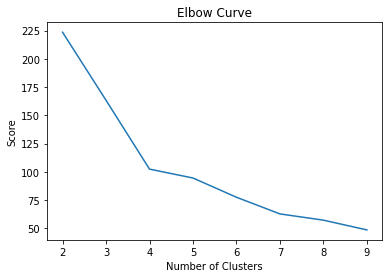

In [272]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

**ii) K-Means Kümeleme Modelini Oluşturma**

K-Means algoritmasını dört küme ile oluşturacağız.

In [273]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

**iii) Müşterilerimiz İçin Tahmin Yapalım.**

Veri kümesindeki her müşteriye kümeler atamak için oluşturduğumuz modeli kullanalım:

In [274]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-------+---------+------------------+----------+---------------------------------+-----------------------------------------------------------+----------+

|recency|frequency|monetary_value    |CustomerID|features                         |standardized                                               |prediction|

+-------+---------+------------------+----------+---------------------------------+-----------------------------------------------------------+----------+

|5580   |14       |226.14            |16250     |[5580.0,14.0,226.14]             |[0.6860448646904733,0.6848507976304105,0.45968090513788235]|0         |

|2580   |1        |350.4             |15100     |[2580.0,1.0,350.4]               |[0.3172035395880683,0.04891791411645789,0.7122675738936676]|0         |

|30360  |14       |205.85999999999999|13065     |[30360.0,14.0,205.85999999999999]|[3.732674210036339,0.6848507976304105,0.4184571996625297]  |2         |

|12660  |59       |390.78999999999985|12838     |[12660.0,59.0,3

# Adım 6: Küme Analizi

Son olarak, yeni oluşturduğumuz müşteri segmentlerini analiz edelim.

Veri çerçevesindeki her bir müşteri kimliğinin recency, frequency ve monetary_value'ini görselleştirelim.

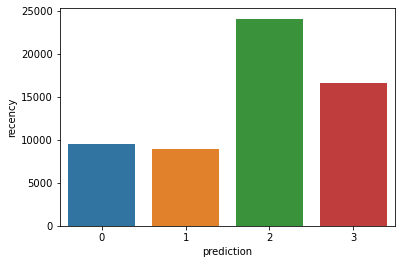

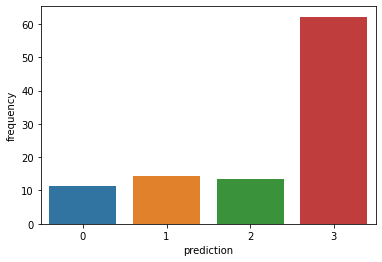

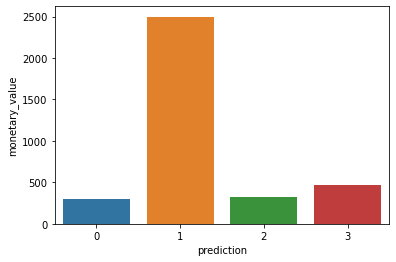

In [275]:
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

İşte her kümede müşteriler tarafından görüntülenen özelliklere genel bir bakış:

**Küme 0**: Bu segmentteki müşteriler düşük yenilik, sıklık ve parasal değer göstermekteler. Platformda nadiren alışveriş yapmışlar ve e-ticaret şirketiyle iş yapmayı bırakma olasılığı düşük potansiyelli müşterilerdir.

**Küme 1**: Bu kümedeki kullanıcılar yüksek yenilik gösteriyor ancak platformda fazla harcama yapmamışlardır. Ayrıca siteyi sık sık ziyaret de etmemektedirler. Bu, şirketle iş yapmaya yeni başlayan, daha yeni müşteriler olabileceklerini söyleyebiliriz.

**Küme 2**: Bu segmentteki müşteriler orta düzeyde yenilik ve sıklık göstermekte ve platformda çok para harcamaktalar. Bu, yüksek değerli ürünler satın alma veya toplu alım yapma eğiliminde olduklarını göstermektedir.

**Küme 3**: Son segment, yüksek yenilik gösteren ve platformda sık sık alışveriş yapan kullanıcıları içermektedir. Bununla birlikte, platformda fazla harcama yapmamakla birlikte, her satın alımda daha ucuz ürünler seçme eğiliminde oldukları anlamına da gelebilmektedir.